<h1><center>DS420 - PE5: Tree Methods</center></h1>

## Introduction:


In this exercise we will use some data to test out 3 different tree methods:

* A single decision tree
* A random forest
* A gradient boosted tree classifier
    
We will be using a college admission dataset to try to classify colleges as Private or Public based off these features:

* **Private:** A factor with levels No and Yes indicating private or public university
* **Apps:** Number of applications received
* **Accept:** Number of applications accepted
* **Enroll:** Number of new students enrolled
* **Top10perc:** Pct. new students from top 10% of H.S. class
* **Top25perc:** Pct. new students from top 25% of H.S. class
* **F_Undergrad:** Number of fulltime undergraduates
* **P_Undergrad:** Number of parttime undergraduates
* **Outstate:** Out-of-state tuition
* **Room_Board:** Room and board costs
* **Books:** Estimated book costs
* **Personal:** Estimated personal spending
* **PhD:** Pct. of faculty with Ph.D.’s
* **Terminal:** Pct. of faculty with terminal degree
* **S_F_Ratio:** Student/faculty ratio
* **perc_alumni:** Pct. alumni who donate
* **Expend:** Instructional expenditure per student
* **Grad_Rate:** Graduation rate

## Section 1: Setup Environment and Load the Data

#### Setup spark path for jupyter notebook

In [120]:

import findspark

findspark.init('/opt/spark')
from pyspark.sql import SparkSession



#### Create a Spark session named as "PE5_xxx", where xxx is your last name.

In [121]:
spark = SparkSession.builder.appName('PE5_moynihan').getOrCreate()





#### Load and parse the data file, converting it to a DataFrame named `data`.

In [122]:
# Load and parse the data file, converting it to a DataFrame.
from pyspark import SparkFiles

url = 'https://raw.githubusercontent.com/BlueJayADAL/DS420/master/datasets/mllib/CollegeAdmission.csv'



In [123]:
spark.sparkContext.addFile(url)
fileloc = SparkFiles.get('CollegeAdmission.csv')
df = spark.read.csv('file://'+fileloc, inferSchema=True, header=True)

#### Show the schema of the DataFrame

In [124]:
df.printSchema()



root
 |-- School: string (nullable = true)
 |-- Private: string (nullable = true)
 |-- Apps: integer (nullable = true)
 |-- Accept: integer (nullable = true)
 |-- Enroll: integer (nullable = true)
 |-- Top10perc: integer (nullable = true)
 |-- Top25perc: integer (nullable = true)
 |-- F_Undergrad: integer (nullable = true)
 |-- P_Undergrad: integer (nullable = true)
 |-- Outstate: integer (nullable = true)
 |-- Room_Board: integer (nullable = true)
 |-- Books: integer (nullable = true)
 |-- Personal: integer (nullable = true)
 |-- PhD: integer (nullable = true)
 |-- Terminal: integer (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumni: integer (nullable = true)
 |-- Expend: integer (nullable = true)
 |-- Grad_Rate: integer (nullable = true)



#### Grab the first row of the DataFrame, and find the student-to-faculty ratio.

In [125]:
# First row
df.head(1)


[Row(School='Abilene Christian University', Private='Yes', Apps=1660, Accept=1232, Enroll=721, Top10perc=23, Top25perc=52, F_Undergrad=2885, P_Undergrad=537, Outstate=7440, Room_Board=3300, Books=450, Personal=2200, PhD=70, Terminal=78, S_F_Ratio=18.1, perc_alumni=12, Expend=7041, Grad_Rate=60)]

#### student-to-faculty ratio of the first row

In [126]:
df.select('S_F_Ratio').show(1)

+---------+
|S_F_Ratio|
+---------+
|     18.1|
+---------+
only showing top 1 row



In [127]:
df.head().asDict()['S_F_Ratio']



18.1

## Section 2: EDA using Pandas

#### Import Pandas, Matplotlib.pyplot and Seaborn

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F


#### There is a private school in the DataFrame with a graduation rate higher than 100%. Try to pinpoint what is the name of that school.

In [129]:

df.filter(df['Grad_Rate'] >100).collect()[0].asDict()['School']

'Cazenovia College'

#### Set that school's graduation rate to 100 so it makes sense. Use the `when ... otherwise` function. [Helpful link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.otherwise.html)

In [130]:
import pyspark.sql.functions as F

In [131]:
data = df.withColumn('Grad_Rate', 
                   F.when(df['Grad_Rate'] > 100,100).otherwise(df['Grad_Rate']))


#### Verify again with the college's name to see if it's fixed.

In [132]:
data.filter(data['School']=='Cazenovia College').show()



+-----------------+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+
|           School|Private|Apps|Accept|Enroll|Top10perc|Top25perc|F_Undergrad|P_Undergrad|Outstate|Room_Board|Books|Personal|PhD|Terminal|S_F_Ratio|perc_alumni|Expend|Grad_Rate|
+-----------------+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+
|Cazenovia College|    Yes|3847|  3433|   527|        9|       35|       1010|         12|    9384|      4840|  600|     500| 22|      47|     14.3|         20|  7697|      100|
+-----------------+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+



#### What's Elizabethtown College's Outstate fee?

In [133]:
data.filter(data['School'] == 'Elizabethtown College').select('Outstate').show()





+--------+
|Outstate|
+--------+
|   14190|
+--------+



#### Create a Pandas DataFrame from the PySpark DataFrame.

In [134]:
data_pd = data.toPandas()



#### Recreate the plot of `Grad_Rate` versus `Room_Board` as shown, where the points are color coded by the `Private` column.

<AxesSubplot:xlabel='Room_Board', ylabel='Grad_Rate'>

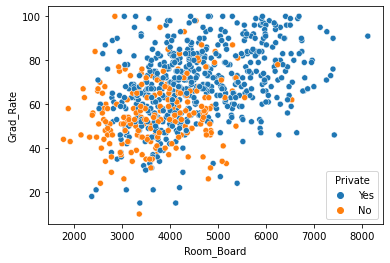

In [135]:
sns.scatterplot(data = data_pd,
               x = 'Room_Board',
               y = 'Grad_Rate',
               hue = 'Private')


#### Create separate histograms for Graduation Rate based on the `Private` column. Use seaborn on this question.

<AxesSubplot:xlabel='Grad_Rate', ylabel='Count'>

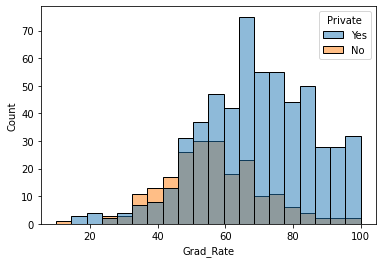

In [136]:
sns.histplot(data = data_pd, x='Grad_Rate',hue='Private',bins=20)



## Section 3: Spark Data Transformation

#### There are a few things we need to do before Spark can accept the data! We need to prepare the data in the form of two columns: ("label","features")

#### Deal with `Private` column being "yes" or "no"

In [137]:
# Import StringIndexer 
from pyspark.ml.feature import StringIndexer



In [138]:
# Create the indexer object and transform the data
# Name the output column PrivateIndex
indexer = StringIndexer(inputCol='Private', outputCol='PrivateIndex')

out_numeric = indexer.fit(data).transform(data)

#### Check for all the existing columns

In [139]:
out_numeric.columns



['School',
 'Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumni',
 'Expend',
 'Grad_Rate',
 'PrivateIndex']

#### Generate the "features" columns so that it contains all the columns other than "School", "Private" and "PrivateIndex".

In [140]:
# Import VectorAssembler 


In [141]:
from pyspark.ml.feature import VectorAssembler

In [142]:
# Create the vector assembler

assembler = VectorAssembler(inputCols=['Apps',
                                         'Accept',
                                             'Enroll',
                                            'Top10perc',
                                             'Top25perc',
                                                'F_Undergrad',
                                            'P_Undergrad',
                                                'Outstate',
                                                 'Room_Board',
                                             'Books',
                                             'Personal',
                                                 'PhD',
                                             'Terminal',
                                             'S_F_Ratio',
                                             'perc_alumni',
                                             'Expend',
                                             'Grad_Rate',],
                           outputCol = 'features')



In [143]:
# Transform the data using the assember

output = assembler.transform(out_numeric)


In [144]:
# Grab the final data that only contains features and label

final_data = output.select(['features', 'PrivateIndex'])



#### Split the dataframe into 70% training and 30% testing. Use seed 101.

In [145]:
trainingData, testingData = final_data.randomSplit([0.7,0.3], seed = 101)


## Section 4: Training and Evaluating the Classifiers

#### Import three classifiers: Decision Tree, Random Forest, and Gradient Boosted Trees.

In [146]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.classification import GBTClassifier



#### Create all three objects out of each classifier with default parameters

In [147]:
# Use mostly defaults to make this comparison "fair"

dtc = DecisionTreeClassifier(labelCol='PrivateIndex')

rfc = RandomForestClassifier(labelCol='PrivateIndex')

gbt = GBTClassifier(labelCol='PrivateIndex')


#### Train all three models

In [148]:
# Train the models (there are three models, so it might take some time)
dtc_model = dtc.fit(trainingData)

rfc_model = rfc.fit(trainingData)

gbt_model = gbt.fit(trainingData)


#### Model Evaluation

#### Let's compare each of these models by firstly generating their predicted results with test data.

In [149]:
dtc_predictions = dtc_model.transform(testingData)

rfc_predictions = rfc_model.transform(testingData)

gbt_predictions = gbt_model.transform(testingData)


#### Evaluate all the model accuracy

In [150]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [153]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol='PrivateIndex',
                                                 metricName='accuracy')



In [154]:
dtc_acc = acc_evaluator.evaluate(dtc_predictions)

rfc_acc = acc_evaluator.evaluate(rfc_predictions)

gbt_acc = acc_evaluator.evaluate(gbt_predictions)


In [155]:
print("Here are the results!")
print('-'*80)
print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*80)
print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*80)
print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))

Here are the results!
--------------------------------------------------------------------------------
A single decision tree had an accuracy of: 89.61%
--------------------------------------------------------------------------------
A random forest ensemble had an accuracy of: 92.21%
--------------------------------------------------------------------------------
A ensemble using GBT had an accuracy of: 90.91%


#### Interesting results! Optional Task - play around with the parameters of each of these models, can you squeeze some more accuracy out of them? Or is the data the limiting factor?

In [156]:
#standardize them
#take out some features to not overfit- check to see if there are inbalances (find weights)
#study correlation scores
#get rid of highly correlated columns